In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project_env as pe
import sklearn as sklearn
from scipy import stats
%matplotlib inline

In [153]:
data = pd.read_csv('merged.csv', encoding = "ISO-8859-1", low_memory=False)
data = data[data['NEXT_ARREST_TIME']!='Delete']
data['NEXT_ARREST_TIME'] = data['NEXT_ARREST_TIME'].apply(pd.to_numeric)
data_simple = pd.read_csv('data_simple.csv', encoding = "ISO-8859-1", low_memory=False)

In [154]:
data = pd.merge(data, \
                 data_simple[['UNIQUE_ID','ADA_CODE']],\
                 on='UNIQUE_ID', \
                 how='left')

In [155]:
data['CHRG_ACCEPTED'] = np.where(data['SCREENING_DISP_CODE']==230,1,0)
data['CHRG_REJECTED'] = np.where(data['SCREENING_DISP_CODE']!=230,1,0)

Cleaning Notes: Most of the bad values do not fit the pattern for the ADA codes. Of those that do, ABRE and
VSAL aren’t listed in the CODE table, but could be AGRE and VSOL, which are ADA codes. These are potential
typos. NARC is a valid code for a different type of variable (drug code), and could be MARC. It appears often
enough that it might not be a typo, and could, instead, indicate confusion on the part of the data entry personel. In
other tables Judge codes have been found in fields that should contain substance codes, and vice-versa, so this does
occur elsewhere. The decision is, however, left to the user, in that the NARC values are considered invalid.
Unaccepted Values: NARC[560]; [Missing][124]; VSAL[6]; NONE[1]; S828672[1]; EWU385[1]; A561575[1];
ABRE[1]

In [156]:
#drop invalid ADA_CODES
invalid_ada_code = ['NARC','VSAL','NONE','S828672','EWU385','A561575','ABRE']
data = data.loc[~data['ADA_CODE'].isin(invalid_ada_code)].dropna(subset=['ADA_CODE'])
data.shape

(204686, 40)

In [157]:
by_sada = data.groupby(['ADA_CODE'])['CHRG_ACCEPTED','CHRG_REJECTED'].sum()

In [158]:
by_sada['NBR_CASES'] = by_sada['CHRG_ACCEPTED'] + by_sada['CHRG_REJECTED'] 
by_sada['CHRG_RATE'] = by_sada['CHRG_ACCEPTED']/(by_sada['NBR_CASES'])

Max # of cases seen by a screener with charge rate = 1 is 14. <br>
Max # of cases seen by a screener with charge rate = 0 is 580.

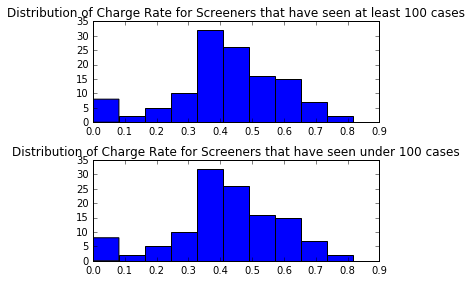

In [159]:
plt.subplot(2, 1, 1)
plt.hist(by_sada[by_sada['NBR_CASES']>=100]['CHRG_RATE'])
plt.title('Distribution of Charge Rate for Screeners that have seen at least 100 cases')
plt.subplot(2, 1, 2)
plt.hist(by_sada[by_sada['NBR_CASES']>=100]['CHRG_RATE'])
plt.title('Distribution of Charge Rate for Screeners that have seen under 100 cases')
plt.tight_layout()
plt.show()

In [160]:
print('Total Screeners: ',by_sada.shape[0])
print('Screeners that have seen over 100 cases: ',by_sada[by_sada['NBR_CASES']>=100].shape[0])
print('Screeners that have seen over 500 cases: ',by_sada[by_sada['NBR_CASES']>=500].shape[0])
print('Mode Cases Seen: ',stats.mode(by_sada['NBR_CASES'])[0])
print('Median Cases Seen: ',np.median(by_sada['NBR_CASES']))
print('Average Cases Seen: ',np.mean(by_sada['NBR_CASES']))

Total Screeners:  250
Screeners that have seen over 100 cases:  123
Screeners that have seen over 500 cases:  78
Mode Cases Seen:  [1]
Median Cases Seen:  92.5
Average Cases Seen:  818.744


# Rearrest rate from human screener decisions

In [161]:
not_charged = data[data['CHRG_ACCEPTED']==0]

# Rearrest rate by leniency

Only considering screeners who have seen over 100 cases.

In [162]:
by_sada[by_sada['NBR_CASES']>=100].index

Index(['ADAI', 'ADIC', 'ALMB', 'ALOG', 'AMON', 'ANEL', 'AWAL', 'BBER', 'BDEA',
       'BLAN',
       ...
       'SRIC', 'SSCI', 'SSMI', 'SWOO', 'TBLO', 'TFAI', 'TSHA', 'VSOL', 'WEIK',
       'YBOL'],
      dtype='object', name='ADA_CODE', length=123)

In [172]:
sada = pd.merge(data, \
                 by_sada[by_sada['NBR_CASES']>=30][['NBR_CASES','CHRG_RATE']],\
                 left_on ='ADA_CODE',\
                right_index = True, \
                 how='inner')

In [173]:
sada['quantile'] = pd.qcut(sada['CHRG_RATE'],5,labels=False)

In [174]:
q_summary = sada.groupby(['quantile'])['CHRG_RATE','NBR_CASES'].mean()
q_summary['NBR_CASES']= sada.groupby(['quantile'])['NBR_CASES'].sum()

q_summary['SHARE_CASES']= q_summary['NBR_CASES']/q_summary['NBR_CASES'].sum()
q_summary

,CHRG_RATE,NBR_CASES,SHARE_CASES
quantile,,,
0,0.232654,160295812,0.179124
1,0.357106,342165294,0.382355
2,0.399416,157895585,0.176442
3,0.465711,92916160,0.103830
4,0.624592,141615669,0.158250


In [175]:
sada_not_charged = sada[sada['CHRG_ACCEPTED']==0]

In [176]:
rearrest_rates = np.zeros((5,5))
years = [1,2,3,4,5]
for q in range(5):
    for year in range(1,6):
        data_trunc = sada_not_charged[(sada_not_charged['ARREST_DATE_y'] <= 1999 - year)&\
                                     (sada_not_charged['quantile']==q)]
        total = data_trunc['SCREENING_DISP_CODE'].count()
        rearrest_cnt = data_trunc[(data_trunc['NEXT_ARREST_TIME'] >0)&(data_trunc['NEXT_ARREST_TIME'] <= year*365)]\
        ['SCREENING_DISP_CODE'].count()
        rearrest_rates[q][year-1] = rearrest_cnt/total
        #print ('Quantile %s: %.0f%% were rearrested within %s years' %(q, rearrest_rate*100, year))
    

In [177]:
pd.DataFrame(rearrest_rates, \
             index = ['Q1','Q2','Q3','Q4','Q5'], \
             columns = ['1_year','2_year','3_year','4_year','5_year'])

,1_year,2_year,3_year,4_year,5_year
Q1,0.287656,0.373177,0.443469,0.473029,0.490116
Q2,0.332992,0.432681,0.479752,0.504869,0.532184
Q3,0.298809,0.412469,0.479581,0.524535,0.554650
Q4,0.291619,0.399655,0.462989,0.504928,0.537404
Q5,0.274218,0.391116,0.447706,0.486504,0.517203
